In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

In [61]:
# Linear Benchmarks
single_results = np.load('results/20aug_test/benchmarks/benchmark_AR_roll.npz')
single_test_preds = single_results['test_preds'] # dim: test_size v n_var (20 x 3)
multi_test_preds = np.load('results/20aug_test/benchmarks/benchmark_multi_AR_roll.npz') # dim: horizons x n_var x test_size x re-estimation_windows (3 x 3 x 20 x 1)
multi_test_preds = multi_test_preds[1, :, :, 0].T # get the h = 1 forecast

In [64]:
single_results = np.load('results/21aug_test/params_0_repeat_0.npz', allow_pickle=True)['results'].item() # n_obs x n_bootstraps x n_var
single_test_preds = single_results['test_preds'] # dim: test_size v n_var (20 x 3)
multi_test_preds = np.load('results/21aug_test/multi_fcast_params_0_repeat_0.npz')['fcast'] # dim: horizons x n_var x n_sim_bootstraps x test_size x re-estimation_windows (3 x 3 x 40 x 20 x 1)
multi_test_preds = multi_test_preds[1, :, :, :, 0].T # get the h = 1 forecast

In [82]:
multi_test_preds

array([[[ 2.45815756e-02,  1.55052884e-03, -4.06832471e-02],
        [ 2.45815756e-02,  1.55052884e-03, -4.06832471e-02],
        [ 2.45815756e-02,  1.55052884e-03, -4.06832471e-02],
        ...,
        [ 2.45815756e-02,  1.55052884e-03, -4.06832471e-02],
        [ 2.45815756e-02,  1.55052884e-03, -4.06832471e-02],
        [ 2.45815756e-02,  1.55052884e-03, -4.06832471e-02]],

       [[ 3.40776446e-02,  2.07171809e-03, -3.58309280e-02],
        [ 3.40776446e-02,  2.07171809e-03, -3.58309280e-02],
        [ 3.40776446e-02,  2.07171809e-03, -3.58309280e-02],
        ...,
        [ 3.40776446e-02,  2.07171809e-03, -3.58309280e-02],
        [ 3.40776446e-02,  2.07171809e-03, -3.58309280e-02],
        [ 3.40776446e-02,  2.07171809e-03, -3.58309280e-02]],

       [[ 3.09978938e-02,  2.03615901e-03, -3.75520254e-02],
        [ 3.09978938e-02,  2.03615901e-03, -3.75520254e-02],
        [ 3.09978938e-02,  2.03615901e-03, -3.75520254e-02],
        ...,
        [ 3.09978938e-02,  2.03615901e-03,

In [71]:
single_test_preds.shape

(20, 20, 3)

In [72]:
multi_test_preds.shape

(20, 40, 3)

In [81]:
single_test_preds[15, :, 1]

array([ 0.01033501, -0.07155656, -0.00183002, -0.00180218, -0.02186896,
       -0.03665635,  0.01326868, -0.01427916, -0.00693649,  0.00161928,
       -0.00372458,  0.00348573,  0.01952894, -0.10532782,  0.02433452,
        0.0021222 ,  0.00889325,  0.01014317, -0.02480734, -0.0387375 ])

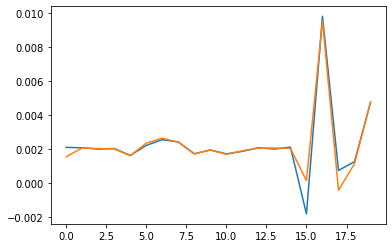

In [80]:
plt.plot(np.nanmedian(single_test_preds[:, :, 1], axis = 1))
plt.plot(np.nanmedian(multi_test_preds[:, :, 1], axis = 1))

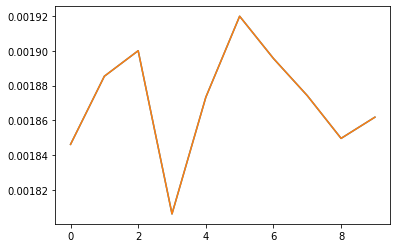

In [63]:
plt.plot(single_test_preds[:10, 1])
plt.plot(multi_test_preds[:10, 1])

In [37]:
single_test_preds

array([[ 7.57502228e-03,  2.21419879e-03, -7.56337040e-03],
       [-1.31846048e-02,  2.45266562e-03, -3.34037991e-02],
       [-5.09794102e-03,  2.47614326e-03, -2.91985281e-02],
       [ 4.75904057e-02,  2.01290079e-03, -5.49818491e-02],
       [-7.45267217e-02,  1.46749896e-03, -2.54434697e-02],
       [-1.55612371e-02,  2.84868823e-03, -3.21662693e-02],
       [ 1.42303205e-02,  2.96307447e-03, -3.01244396e-02],
       [ 2.01317662e-02,  2.84402515e-03, -5.11633455e-02],
       [-1.44261693e-02,  1.82007402e-03, -3.03490321e-02],
       [-4.38467965e-02,  2.01366453e-03, -1.93274332e-02],
       [-4.79402719e-02,  1.43122039e-03, -2.16972279e-02],
       [-6.41306246e-02,  2.24859532e-03, -1.87795375e-02],
       [ 1.77139299e-02,  1.88803159e-03, -1.54440409e-02],
       [-1.51786116e-03,  1.88740065e-03, -2.20329944e-02],
       [ 6.25037773e-02,  1.91617640e-03, -3.84524005e-02],
       [-1.55054442e+00, -9.06141861e-03,  1.12363048e+00],
       [-1.34152188e-01,  1.50339243e-02